In [1]:
# A script for me to explain the correlation between thermo and kinetics to myself

## (Some) reaction rates depend on species thermo

$k=AT^be^{-E_a/RT}$

For BEP relations, $E_a$ is a function of the enthalpy of reaction, which depends on species enthalpies

$E_a$ = $E_a(\Delta H_{rxn}) = E_0 + \alpha \Delta H_{rxn} = E_0 + \alpha \sum_i {\nu_i} H_{i}$

Where ${\nu_i}$ is the stoichiometric coefficient and $H_{i}$ is the enthalpy for species $i$.

We can rewrite this as a sum using properties of logs

$\ln k=\ln A +b\ln T - \frac{E_0}{RT} - \alpha \frac{\sum_i {\nu_i} H_{i}}{RT}$

# Each term is an independent source of uncertainty

(This isn't entirely accurate because species calculated using the same DFT method will have correlated/systematic errors, but it's the best we can do without digging into the details of
the BEEF-vdW results. Also, if the reactions are part of the same family, the $E_0$s are probably also correlated.)

We assume each term is independent of the others: $A, b, E_0, H_i$

(Assuming here that $\alpha$ isn't uncertain)

So, if we have two reactions:

$$\ln k_1=\ln A_1 +b_1\ln T - \frac{E_{0,1}}{RT} - \alpha_1 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

$$\ln k_2=\ln A_2 +b_2\ln T - \frac{E_{0,2}}{RT} - \alpha_2 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

and want to know the covariance between them $cov(\ln k_1, \ln k_2)$

The assumptions of independence mean that the only the $\alpha_1 \frac{{\nu_i} H_{i}}{RT}$ terms will be nonzero, and only when the same species appears in both reactions.

# Let's look at an example in RMG

In [166]:
import os
import copy
import itertools
import numpy as np
import scipy.stats
import rmgpy.data.thermo
import rmgpy.data.rmg
import matplotlib.pyplot as plt
%matplotlib inline

### Load the database

In [191]:
# Load the database
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = ['surfaceThermoPt111', 'primaryThermoLibrary'],
    reaction_libraries = ['Surface/CPOX_Pt/Deutschmann2006_adjusted'],
    kinetics_families = ['Surface_Abstraction'],
    kinetics_depositories = ['training'],
    depository = True,
)

### Define/display our example reactions

Reaction 1: CH2X + HOX <=> CH3X + OX

Reaction 2: CHX + HOX <=> CH2X + OX


Reaction 1:


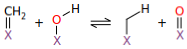


Reaction 2:


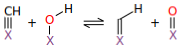


Reaction 3:


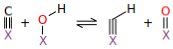


Reaction 4:


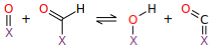

In [212]:
family = 'Surface_Abstraction'
training_depository = database.kinetics.families[family].get_training_depository()
my_reactions = []
for i, entry in enumerate(training_depository.entries):
    print(f'Reaction {i + 1}:')
    display(training_depository.entries[entry].item)
    my_reactions.append(training_depository.entries[entry].item)
    print()

### Look up the BEP kinetics corresponding to each reaction

Note that the training reactions themselves have regular Arrhenius kinetics.
We need to use RMG's kinetics decision tree to get the BEP version.

In [213]:
# Get the kinetics from the RMG family's decision tree
for i, rxn in enumerate(my_reactions):
    print(f'Reaction {i + 1}:')
    
    template_labels = database.kinetics.families[family].get_reaction_template_labels(rxn)
    template = database.kinetics.families[family].retrieve_template(template_labels)
    kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=rxn.degeneracy)[0]
    my_reactions[i].kinetics = kinetics
    print(kinetics)
    print()

Reaction 1:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C=*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 2:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C#*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 3:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C$*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 4:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.94, E0=(129.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using te

Note that 3/4 of the examples have identical BEP parameters, but will have different $\ln k$
because of the dependence on $\Delta H_{rxn}$

### Grab the species thermo from the database so we can calculate $\Delta H_{rxn}$

In [214]:
lib = database.thermo.libraries['surfaceThermoPt111']
for i, rxn in enumerate(my_reactions):
    for j in range(len(rxn.reactants)):
        my_reactions[i].reactants[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].reactants[j],
            lib
        )[0]
    for j in range(len(rxn.products)):
        my_reactions[i].products[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].products[j],
            lib
        )[0]

# Plot the kinetics to see what they are

In [171]:
def plot_kinetics(rxns, labels=None, title=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')
    linestyles = ['solid', 'dashed', 'dotted', 'solid']
    if type(rxns) != list:
        rxns = [rxns]
    P = 101325
    T = np.linspace(300, 3000, 1001)
    for j, rxn in enumerate(rxns):
        Tmax = max(T)
        if hasattr(rxn, 'reactants'):
            Tmax = min([sp.thermo.Tmax.value_si for sp in rxn.reactants + rxn.products])
        k = np.zeros(len(T)) * np.nan
        for i in range(0, len(T)):
            if T[i] > Tmax:
                break
            if type(rxn) == rmgpy.kinetics.surface.SurfaceArrhenius:
                k[i] = rxn.get_rate_coefficient(T[i], P)
            else:
                my_reactions[0].reactants[0].thermo.Tmax.value_si
                k[i] = rxn.kinetics.get_rate_coefficient(T[i], dHrxn=rxn.get_enthalpy_of_reaction(T[i]))

            
        plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[j % len(linestyles)])

    if labels:
        plt.legend(labels)
    if title:
        plt.title(title)
#     plt.show()

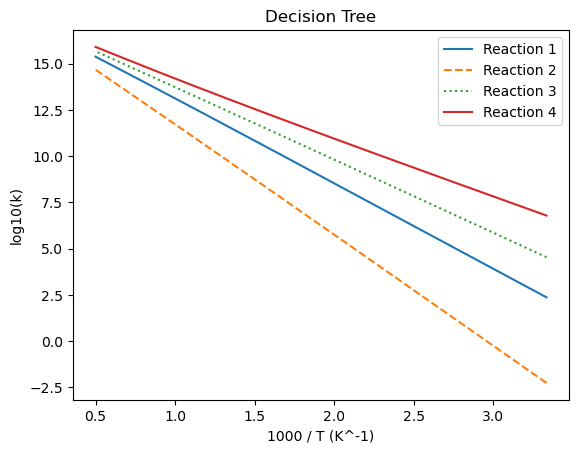

In [172]:
# show kinetics
plot_kinetics(my_reactions, labels=[f'Reaction {i}' for i in range(1, 5)], title='Decision Tree')


In [173]:
# # Shows that training reaction kinetics don't necessary match decision tree kinetics exactly
# training_kinetics = [training_depository.entries[entry].data for entry in training_depository.entries]
# plot_kinetics(my_reactions + training_kinetics, labels=[f'Decision {i}' for i in range(1, 5)] + [f'Training {i}' for i in range(1, 5)])

# Do the theoretical calculation and see how it compares to random sampling

For simplicity, I will assume all the uncertainty is in the species enthalpies.

We can add in the uncertainty from A, b, and E0 later

We have already assumed those are all uncorrelated to each other (or at least uncorrelated to the values in other nodes in the decision tree)

## Define our species indices and uncertainties

0



1


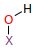


2


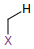


3



4



5



6


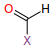


7


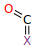

In [195]:
def species_in_list(new_species, species_list):
    for sp in species_list:
        if new_species.is_isomorphic(sp):
            return True
    return False

def get_species_index(query_species, species_list):
    for i in range(len(species_list)):
        if query_species.is_isomorphic(species_list[i]):
            return i
    return -1

species = []

for rxn in my_reactions:
    for s in rxn.reactants + rxn.products:
        if not species_in_list(s, species):
            species.append(s)
for i in range(len(species)):
    print(i)
    display(species[i])
    print()

In [198]:
species[0].thermo

NASA(polynomials=[NASAPolynomial(coeffs=[-2.23007,0.0292223,-4.33155e-05,3.31428e-08,-9.96471e-12,-222.256,8.30173], Tmin=(298,'K'), Tmax=(1000,'K')), NASAPolynomial(coeffs=[6.8346,-0.00514926,9.15491e-06,-4.84917e-09,8.63767e-13,-2258.98,-36.2215], Tmin=(1000,'K'), Tmax=(2000,'K'))], Tmin=(298,'K'), Tmax=(2000,'K'), Cp0=(0.01,'J/(mol*K)'), CpInf=(99.7737,'J/(mol*K)'), label="""XCH2""")

Recall we had

$$\ln k_m=\ln A_m +b_m\ln T - \frac{E_{0,m}}{RT} - \alpha_m \frac{\sum_i {\nu_i} H_{i}}{RT}$$

Variance of $\ln k_m$ is denoted as $Var(\ln k_m)$ and sometimes ${(\Delta \ln k_m)}^2$

Standard deviation of $\ln k_m$ is denoted as $Std(\ln k_m)$ and sometimes $\Delta \ln k_m$

Covariance of $\ln k_m$ and $\ln k_n$, or $Cov(\ln k_m, \ln k_n)$ will be a sum of variance terms where the $\alpha_m \frac{ {\nu_i} H_{i}}{RT}$ parts match up

$$Cov(\ln k_m, \ln k_n) = \frac{\alpha_m \alpha_n}{{(RT)}^2} \sum_i^{rxn_m} \sum_j^{rxn_n} \delta_{sp,i}\delta_{sp,j} \nu_i \nu_j {Var(H_i)}$$


## Build the Covariance Matrix (for a fixed T=1000K)

In [178]:
cov_matrix_theory = np.zeros((len(my_reactions), len(my_reactions)))

varH = np.float_power(28945.5, 2.0) ## 0.3 eV converted to J/mol and then squared
R = 8.314472
T = 1000.0
for i in range(len(my_reactions)):
    for j in range(len(my_reactions)):
        rxn_i = my_reactions[i]
        rxn_j = my_reactions[j]
        for k in range(len(species)):
            if species_in_list(species[k], rxn_i.reactants):
                nu_i = -1
            elif species_in_list(species[k], rxn_i.products):
                nu_i = 1
            else:
                nu_i = 0
                
            if species_in_list(species[k], rxn_j.reactants):
                nu_j = -1
            elif species_in_list(species[k], rxn_j.products):
                nu_j = 1
            else:
                nu_j = 0
            
            alpha_i = my_reactions[i].kinetics.alpha.value_si
            alpha_j = my_reactions[j].kinetics.alpha.value_si
            cov_matrix_theory[i, j] += nu_i * nu_j * alpha_i * alpha_j * varH / np.float_power(R * T, 2.0)

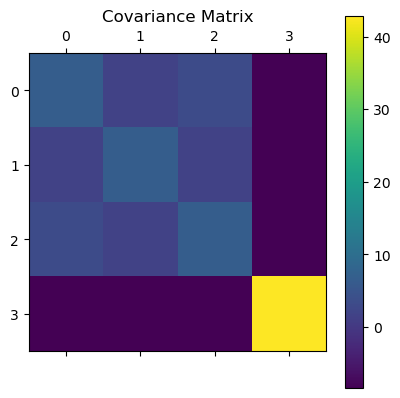

In [179]:
plt.matshow(cov_matrix_theory)
plt.title('Covariance Matrix')
plt.colorbar()


In [180]:
print(cov_matrix_theory)

[[ 6.63676135  1.65919034  3.31838067 -8.43048063]
 [ 1.65919034  6.63676135  1.65919034 -8.43048063]
 [ 3.31838067  1.65919034  6.63676135 -8.43048063]
 [-8.43048063 -8.43048063 -8.43048063 42.83595564]]


## Plot joint pdfs

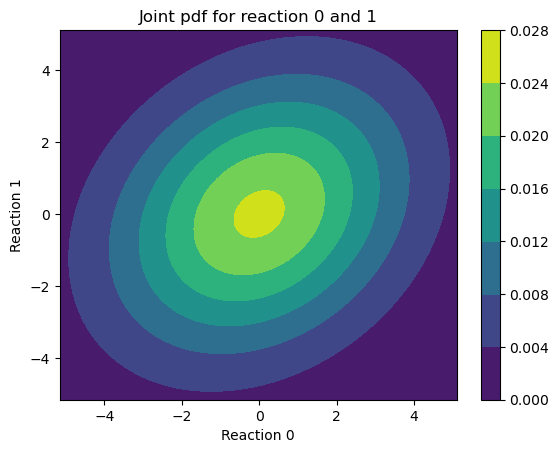

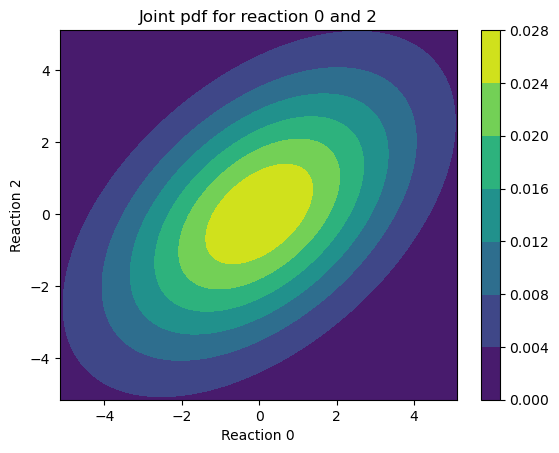

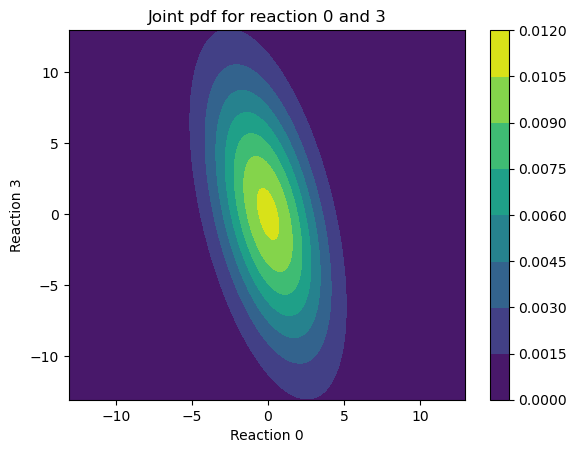

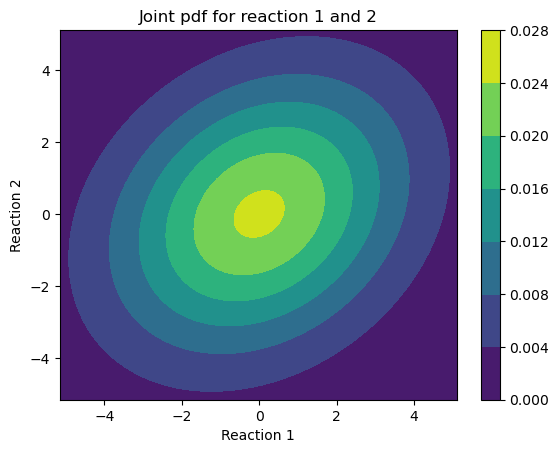

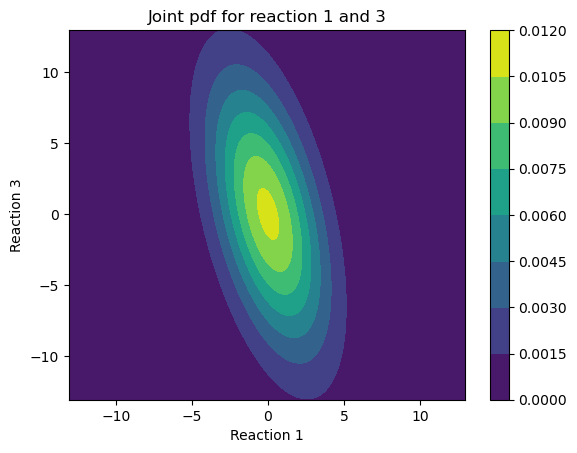

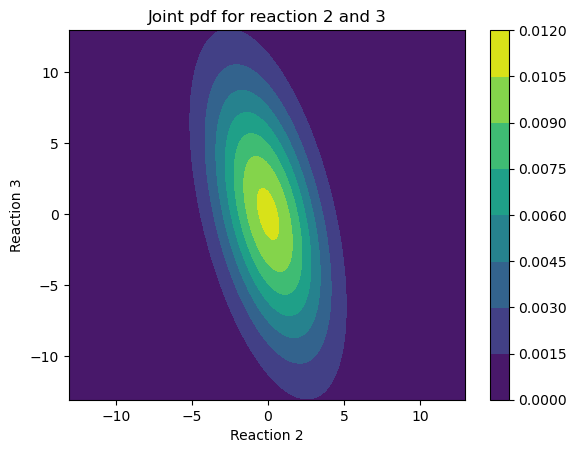

In [181]:
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

combos = itertools.combinations(range(cov_matrix_theory.shape[0]), 2)


for combo in combos:
    i, j = combo
    
    my_cov = np.zeros((2, 2))
    my_cov[0, 0] = cov_matrix_theory[i, i]
    my_cov[0, 1] = cov_matrix_theory[i, j]
    my_cov[1, 0] = cov_matrix_theory[j, i]
    my_cov[1, 1] = cov_matrix_theory[j, j]
    
    assert is_pos_def(my_cov)

    scipy_dist = scipy.stats.multivariate_normal(np.zeros(my_cov.shape[0]), cov=my_cov)

    dimension = 2 * np.sqrt(np.max(np.abs(my_cov)))  # 2 standard deviations is about 95%
    increment = dimension / 100
    x, y = np.mgrid[-dimension:dimension:increment, -dimension:dimension:increment]

    pos = np.dstack((x, y))

    plt.contourf(x, y, scipy_dist.pdf(pos))
    plt.colorbar()
    plt.title(f'Joint pdf for reaction {i} and {j}')
    plt.xlabel(f'Reaction {i}')
    plt.ylabel(f'Reaction {j}')
    plt.show()

# Now compare to a sampling experiment!

In [316]:
# Define the covariance of species thermo (all independent to it's just a diagonal matrix)
# for multivariate sampling
H_cov = np.diag(np.array([varH] * len(species)))

N = 10000
np.random.seed(400)
perturbations = np.random.multivariate_normal(np.zeros(len(species)), cov=H_cov, size=N)



## For each sample, perturb the thermo and recalculate the kinetics

### Test perturb function by plotting thermo before and after

In [317]:
R = 8.3144598  # gas constant in J/mol
def perturb_species_thermo(species, delta_j_mol):
    # takes in an RMG thermo object (uses NASA polynomials)
    # http://combustion.berkeley.edu/gri_mech/data/nasa_plnm.html  <--- NASA Polynomials
    # change the enthalpy offset by delta_j_mol, the perturbation in Joules / mol
    increase = None
    for poly in species.thermo.polynomials:
        new_coeffs = poly.coeffs
        if not increase:
            # Only define the increase in enthalpy once or you'll end up with numerical gaps in continuity
            # increase = DELTA * new_coeffs[5]
            increase = delta_j_mol / R
        new_coeffs[5] += increase
        poly.coeffs = new_coeffs


In [318]:
def plot_thermos(thermos, labels=None):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
    linestyles = ['solid', 'dashed']
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for j, thermo in enumerate(thermos):
        Tmax = max(T)
        if hasattr(thermo, 'thermo'):
            Tmax = thermo.thermo.Tmax.value_si
        elif hasattr(thermo, 'Tmax'):
            Tmax = thermo.Tmax.value_si
        H = np.zeros(len(T)) * np.nan
        S = np.zeros(len(T)) * np.nan
        Cp = np.zeros(len(T)) * np.nan
        for i in range(0, len(T)):
            if T[i] > Tmax:
                break
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H, linestyle=linestyles[j % len(linestyles)])
        ax[1].plot(T, S, linestyle=linestyles[j % len(linestyles)])
        ax[2].plot(T, Cp, linestyle=linestyles[j % len(linestyles)])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

### By design, only enthalpy changes from perturbation 

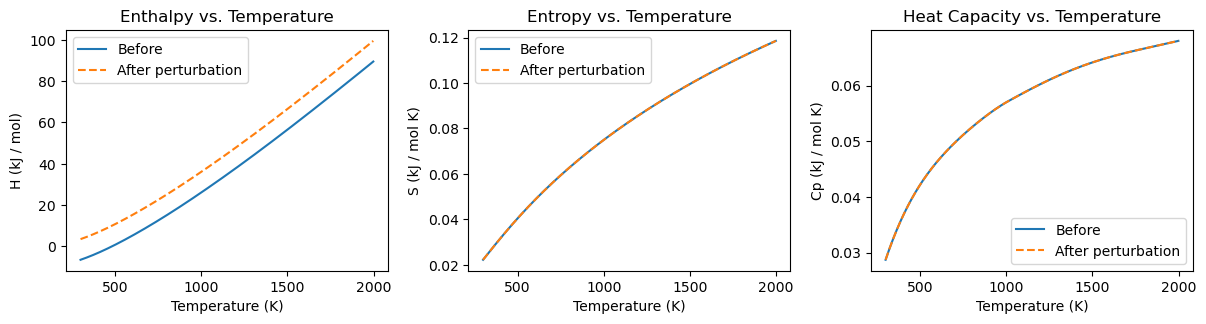

In [319]:
before = species[0]
perturbed = copy.deepcopy(before)
perturb_species_thermo(perturbed, 10000)

plot_thermos([before, perturbed], ['Before', 'After perturbation'])

### Now perturb thermo according to underlying thermo covariance matrix
#### (Thermo covariance matrix is just a diagonal -- all independent)

#### Get resulting kinetics at T=1000K

In [320]:
T = 1000
resulting_lnk = np.zeros((N, len(my_reactions)))
base_species = [copy.deepcopy(sp) for sp in species]
base_reactions = [copy.deepcopy(rxn) for rxn in my_reactions]
for i in range(N):
    # perturb the thermo according to the random sample
    perturbed_sp = [copy.deepcopy(sp) for sp in base_species]
    for j in range(len(perturbed_sp)):
        perturb_species_thermo(perturbed_sp[j], perturbations[i, j])
        
    # Thread in the new thermo for each reaction
    for j in range(len(my_reactions)):
        for k in range(len(my_reactions[j].reactants)):
            query_species = my_reactions[j].reactants[k]
            my_reactions[j].reactants[k].thermo = perturbed_sp[get_species_index(query_species, perturbed_sp)].thermo
        for k in range(len(my_reactions[j].products)):
            query_species = my_reactions[j].products[k]
            my_reactions[j].products[k].thermo = perturbed_sp[get_species_index(query_species, perturbed_sp)].thermo
        resulting_lnk[i, j] = np.log(my_reactions[j].kinetics.get_rate_coefficient(T, dHrxn=my_reactions[j].get_enthalpy_of_reaction(T)))
my_reactions = base_reactions
        
print('Done')
    

Done


### As a sanity check, make sure the mean values are about equal to the nominal value

In [332]:
# Mean of sampled reaction rates
print('Mean')
print(np.mean(resulting_lnk, axis=0))
print('Median')
print(np.median(resulting_lnk, axis=0))
print()
print()
print('Nominal')
# Nominal reaction rates
print(np.log([r.kinetics.get_rate_coefficient(T, dHrxn=r.get_enthalpy_of_reaction(T)) for r in my_reactions]))


Mean
[30.6552475  27.51043404 28.8222993  28.60374083]
Median
[30.6190252  27.53362852 28.81191338 28.71544933]


Nominal
[30.21739779 26.99141    31.61919726 32.69006724]


In [329]:
np.var(resulting_lnk, axis=0)

array([ 6.53628613,  6.72693178,  6.51537925, 39.17461817])

In [322]:
# Now get the statistics of the sample and compare to the theoretical

In [330]:
cov_sampled = np.cov(np.transpose(resulting_lnk), bias=True)

In [331]:
cov_sampled

array([[ 6.53628613,  1.51874405,  3.1797819 , -7.95483472],
       [ 1.51874405,  6.72693178,  1.55424542, -7.80463403],
       [ 3.1797819 ,  1.55424542,  6.51537925, -7.93258674],
       [-7.95483472, -7.80463403, -7.93258674, 39.17461817]])

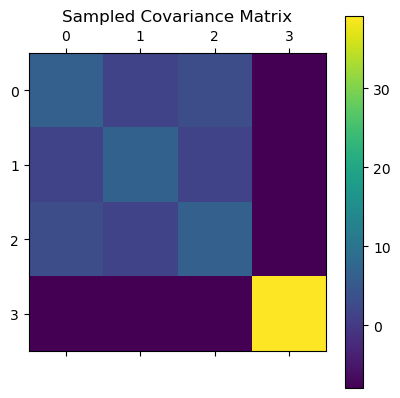

In [324]:
plt.matshow(cov_sampled)
plt.title('Sampled Covariance Matrix')
plt.colorbar()

In [325]:
cov_sampled

array([[ 6.53628613,  1.51874405,  3.1797819 , -7.95483472],
       [ 1.51874405,  6.72693178,  1.55424542, -7.80463403],
       [ 3.1797819 ,  1.55424542,  6.51537925, -7.93258674],
       [-7.95483472, -7.80463403, -7.93258674, 39.17461817]])

### Plot the differences between the two

Text(0.5, 1.0, 'Error between sample and theory N=10000')

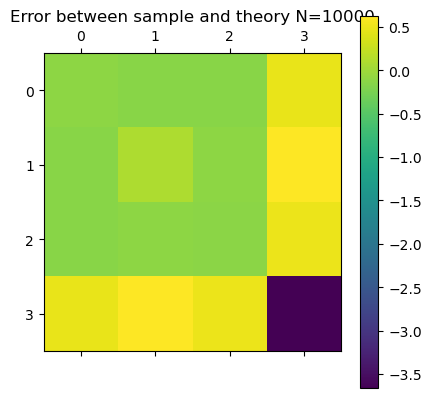

In [326]:
cov_diff = cov_sampled - cov_matrix_theory
plt.matshow(cov_diff)
plt.colorbar()
plt.title(f'Error between sample and theory N={N}')

In [327]:
print(np.mean(np.abs(cov_diff)))

0.4962573730696221
